In [ ]:
import yfinance as yf
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import trange, tqdm

In [2]:
ticker = "BTC-USD"

In [3]:
def get_stock_data(stock_name, start_date, end_date, interval='1d'):
    try:
        df = yf.download(stock_name, start=start_date, end=end_date, interval=interval)
        return df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [56]:
stock_data = get_stock_data(ticker, "2025-03-11", "2025-03-15", '1m')

[*********************100%***********************]  1 of 1 completed


In [57]:
row_counts = stock_data.resample("D").size()
row_counts

Datetime
2025-03-11 00:00:00+00:00    1085
2025-03-12 00:00:00+00:00    1072
2025-03-13 00:00:00+00:00    1060
2025-03-14 00:00:00+00:00    1064
Freq: D, dtype: int64

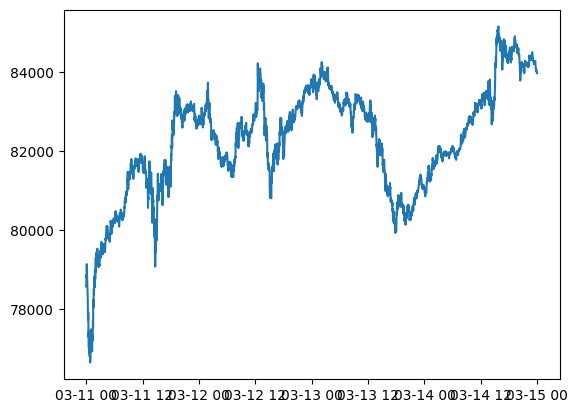

In [58]:
import matplotlib.pyplot as plt

plt.plot(stock_data['Close'])

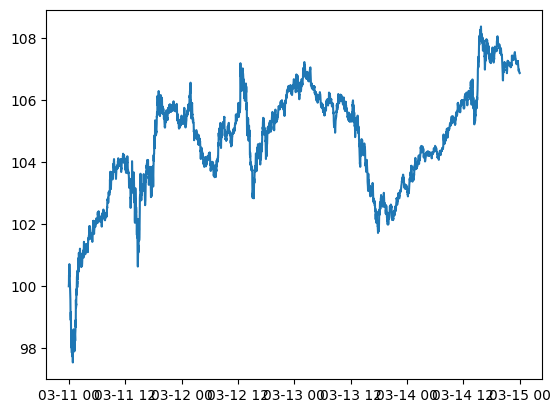

In [59]:
plt.plot(stock_data['Close'] / stock_data['Close'].iloc[0] * 100)

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim

In [61]:
stock_data.columns

MultiIndex([( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

In [67]:
stock_data.columns

Index(['Close_BTC-USD', 'High_BTC-USD', 'Low_BTC-USD', 'Open_BTC-USD',
       'Volume_BTC-USD'],
      dtype='object')

In [66]:
initial_val = stock_data.iloc[0]['Open'][f'{ticker}']
stock_data.columns = ['_'.join(col) for col in stock_data.columns]
stock_pcts = stock_data.pct_change()
stock_pcts_res = stock_pcts.iloc[1:]
stock_pcts_res = stock_pcts_res[f'Open_{ticker}']
means, stds = stock_pcts_res.mean(), stock_pcts_res.std()
stock_pcts_res_norm = (stock_pcts_res - means) / stds

In [68]:
class BaselineRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2, breed='GRU'):
        super(BaselineRNN, self).__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True) if breed == 'GRU' else nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.act = nn.SiLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, nn.GRU) or isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if "weight_ih" in name:  # Input-hidden weights
                    nn.init.xavier_uniform_(param)
                elif "weight_hh" in name:  # Hidden-hidden weights
                    nn.init.orthogonal_(param)
                elif "bias" in name:  # Bias terms
                    nn.init.zeros_(param)
        elif isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight, nonlinearity='linear')
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x):
        # x shape: (seq_len, batch_size, input_size)
        out, h_n = self.rnn(x)  # out.shape = (batch_size, seq_len, hidden_size)
        out = self.fc1(out) # out.shape = (batch_size, seq_len, hidden_size)
        out = self.fc2(self.act(out))  # out.shape = (batch_size, seq_len, output_size)
        return out

In [69]:
class MyDataset(Dataset):
    def __init__(self, data, seq_len, device='cpu'):
        self.data = data
        self.seq_len = seq_len
        self.device = device

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        idx = idx % len(self)
        X = self.data[idx: idx + self.seq_len]
        y= self.data[idx + 1: idx + self.seq_len + 1]
        return torch.tensor(X, dtype=torch.float32, device=self.device), torch.tensor(y, dtype=torch.float32, device=self.device)

In [13]:
SEQ_LEN = 700
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 256
PARTITION = 0.8

val_idx, actual_val_pred_idx = 1000, 300
data = stock_pcts_res_norm[:-val_idx].values.reshape(-1, 1)

In [14]:
dataset = MyDataset(data, SEQ_LEN, DEVICE)

len(dataset)

train_size, test_size = int(len(dataset) * PARTITION), len(dataset) - int(len(dataset) * PARTITION)
training_data, testing_data = random_split(dataset, [train_size, test_size])

print(len(training_data))

train_loader = DataLoader(training_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(testing_data, batch_size=BATCH_SIZE)

NUM_LAYERS = 2
HID_DIM = 64
DROPOUT = 0.5
LR = 1e-4
NB_EPOCHS = 200
COEF = 0.5

2064


In [15]:
def train(input_size, hidden_size, output_size, num_layers, dropout, breed):
    input_size = data.shape[1]
    hidden_size = HID_DIM
    output_size = data.shape[1]
    num_layers = NUM_LAYERS
    dropout = DROPOUT

    model = BaselineRNN(input_size, hidden_size, output_size, num_layers, dropout, breed).to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters())

    best_val_loss = float('inf')

    pbar = tqdm(range(NB_EPOCHS), desc="Epochs", unit="epoch", leave=True)
    for epoch in pbar:
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            running_loss = running_loss * (1 - COEF) + loss.item() * COEF

        test_loss = 0.0
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                output = model(X_batch)
                test_loss = test_loss * (1 - COEF) + criterion(output, y_batch).item() * COEF

        pbar.set_postfix({'Train Loss': f'{running_loss:.4f}', 'Val Loss': f'{test_loss:.4f}'})
        # Checkpoint if validation loss improves
        if test_loss < best_val_loss:
            best_val_loss = test_loss
            torch.save(model.state_dict(), f'best_model_{breed}.pth')

In [16]:
for breed in ['GRU', 'LSTM']:
    train(data.shape[1], HID_DIM, data.shape[1], NUM_LAYERS, DROPOUT, breed)

Epochs: 100%|█████████████████████████████████| 200/200 [04:12<00:00,  1.26s/epoch, Train Loss=0.1282, Val Loss=0.0752]


In [17]:
stock_pcts_res[-val_idx:]

Datetime
2025-03-14 01:29:00+00:00   -0.000171
2025-03-14 01:30:00+00:00   -0.000203
2025-03-14 01:31:00+00:00    0.000973
2025-03-14 01:33:00+00:00    0.000918
2025-03-14 01:34:00+00:00   -0.000193
                               ...   
2025-03-14 23:52:00+00:00   -0.000102
2025-03-14 23:54:00+00:00   -0.000139
2025-03-14 23:55:00+00:00   -0.000126
2025-03-14 23:56:00+00:00    0.000011
2025-03-14 23:58:00+00:00   -0.000054
Name: Open_BTC-USD, Length: 1000, dtype: float64

In [18]:
stock_pcts_res_norm[-val_idx:].shape

(1000,)

In [19]:
result_df = stock_pcts_res[-val_idx:].copy().to_frame()
result_df = result_df.iloc[SEQ_LEN:]

for breed in ['GRU', 'LSTM']:
    model = BaselineRNN(data.shape[1], HID_DIM, data.shape[1], NUM_LAYERS, DROPOUT, breed).to(DEVICE)
    model.load_state_dict(torch.load(f'best_model_{breed}.pth'))
    model.eval()

    df_subset = stock_pcts_res_norm[-val_idx:].copy().to_frame()

    def create_sequences(df):
        X = []
        for i in range(len(df) - SEQ_LEN + 1):
            X.append(torch.tensor((df.iloc[i:i + SEQ_LEN]).values, dtype=torch.float32, device=DEVICE))
        return torch.stack(X, dim=0)

    X = create_sequences(df_subset)
    predictions = model(X.clone().detach())[:-1]  # Shape: (n_samples, seq_len, n_features)

    last_step_predictions = predictions[:, -1, :]  * torch.tensor(np.array(stds).reshape(1, -1), device=DEVICE) + torch.tensor(np.array(means).reshape(1, -1), device=DEVICE)

    pred_columns = [f'{breed}_Pred_{col.split("_")[0]}_{ticker}' for col in df_subset.columns]
    pred_df = pd.DataFrame(last_step_predictions.detach().cpu().numpy(), index=df_subset.index[SEQ_LEN:], columns=pred_columns)

    for col in pred_df.columns:
        result_df[col] = pred_df[col]

C:\Users\elais\AppData\Local\Temp\ipykernel_36412\1709909562.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{breed}.pth'))

In [20]:
result_df.copy()[-100:]

,Open_BTC-USD,GRU_Pred_Open_BTC-USD,LSTM_Pred_Open_BTC-USD
Datetime,,,
2025-03-14 21:52:00+00:00,0.000514,0.000605,0.000275
2025-03-14 21:53:00+00:00,0.000212,0.000844,0.000135
2025-03-14 21:54:00+00:00,0.000056,0.000633,-0.000284
2025-03-14 21:55:00+00:00,-0.000466,0.000318,-0.000627
2025-03-14 21:57:00+00:00,-0.000191,-0.000132,-0.000748
...,...,...,...
2025-03-14 23:52:00+00:00,-0.000102,-0.000470,0.000282
2025-03-14 23:54:00+00:00,-0.000139,-0.000364,0.000011
2025-03-14 23:55:00+00:00,-0.000126,-0.000361,0.000193


In [98]:
last_check_idx = 100

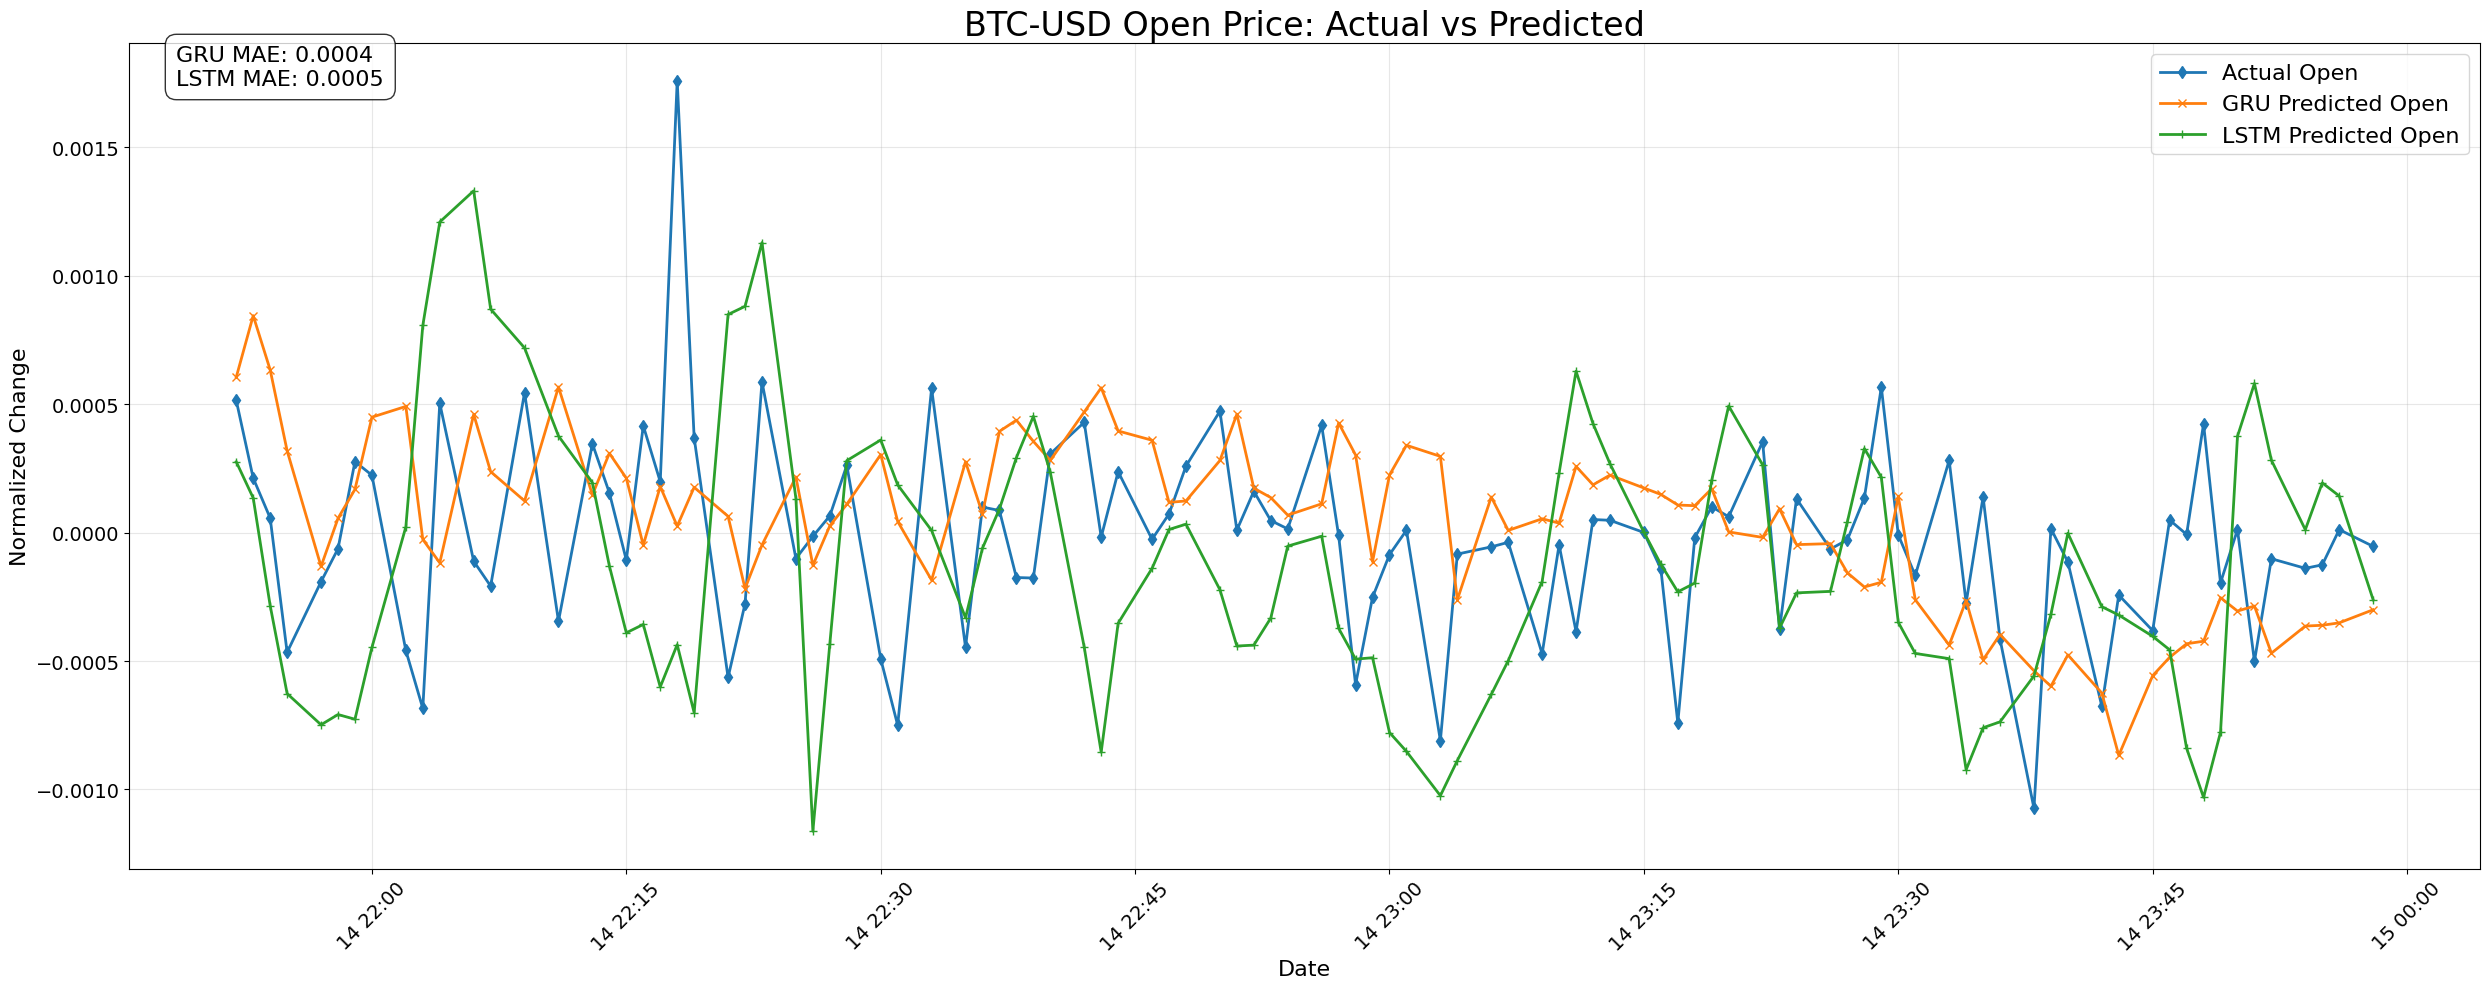

In [21]:
df_pred = result_df.copy()[-last_check_idx:]
timeline = df_pred.index

# Create a single large figure
plt.figure(figsize=(25, 10))

# Create the Open price plot
plt.plot(timeline, df_pred[f'Open_{ticker}'], label='Actual Open', marker='d', linewidth=2)
plt.plot(timeline, df_pred[f'GRU_Pred_Open_{ticker}'], label='GRU Predicted Open', marker='x', linewidth=2)
plt.plot(timeline, df_pred[f'LSTM_Pred_Open_{ticker}'], label='LSTM Predicted Open', marker='+', linewidth=2)

# Add labels and formatting
plt.xlabel('Date', fontsize=16)
plt.ylabel('Normalized Change', fontsize=16)
plt.title(f'{ticker} Open Price: Actual vs Predicted', fontsize=24)
plt.legend(fontsize=16)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Calculate metrics for annotation
gru_mae = np.mean(np.abs(df_pred[f'Open_{ticker}'] - df_pred[f'GRU_Pred_Open_{ticker}']))
lstm_mae = np.mean(np.abs(df_pred[f'Open_{ticker}'] - df_pred[f'LSTM_Pred_Open_{ticker}']))

# Add metrics as text annotation
plt.annotate(f'GRU MAE: {gru_mae:.4f}\nLSTM MAE: {lstm_mae:.4f}',
             xy=(0.02, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
             fontsize=16)

plt.tight_layout()
plt.show()

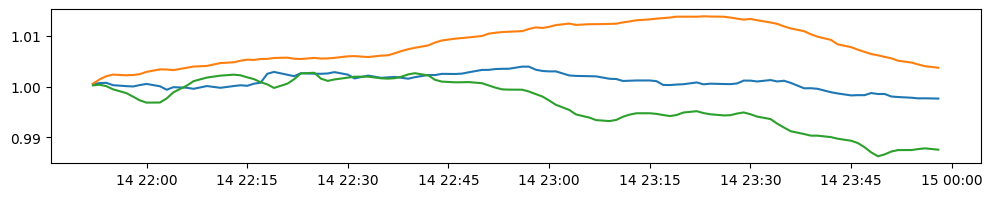

In [107]:
plt.figure(figsize=(12, 2))
plt.plot(timeline, (1 + df_pred).cumprod())
# Trend

In [27]:
df_pred.columns

Index(['Open_BTC-USD', 'GRU_Pred_Open_BTC-USD', 'LSTM_Pred_Open_BTC-USD'], dtype='object')

In [42]:
for col in df_pred.columns[1:]:
    print(col, (np.sign(df_pred.iloc[:, 0]) == np.sign(df_pred[col])).sum() / df_pred.shape[0])

GRU_Pred_Open_BTC-USD 0.55
LSTM_Pred_Open_BTC-USD 0.56


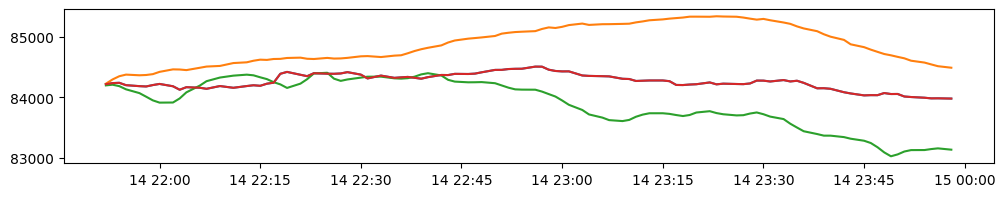

In [105]:
plt.figure(figsize=(12, 2))
plt.plot(timeline, stock_data['Close_BTC-USD'].iloc[-last_check_idx-1] * (1 + df_pred).cumprod())
plt.plot(timeline, stock_data['Close_BTC-USD'].iloc[-last_check_idx:])

In [104]:
(stock_data['Close_BTC-USD'].iloc[-last_check_idx] * (1 + df_pred.iloc[:, 0]).cumprod()).diff()[1:]

Datetime
2025-03-14 21:53:00+00:00    17.860741
2025-03-14 21:54:00+00:00     4.760259
2025-03-14 21:55:00+00:00   -39.285814
2025-03-14 21:57:00+00:00   -16.125475
2025-03-14 21:58:00+00:00    -5.315232
                               ...    
2025-03-14 23:52:00+00:00    -8.566903
2025-03-14 23:54:00+00:00   -11.701326
2025-03-14 23:55:00+00:00   -10.567931
2025-03-14 23:56:00+00:00     0.953615
2025-03-14 23:58:00+00:00    -4.525763
Name: Open_BTC-USD, Length: 99, dtype: float64

In [102]:
stock_real_movement = stock_data['Close_BTC-USD'].iloc[-last_check_idx] * (1 + df_pred.iloc[:, 0]).cumprod()

In [103]:
# Supposedly profit form selling when future is dim, buying when its pink, each 2mins starting over.
for col in df_pred.columns[1:]:
    print(col, (np.sign(df_pred[col])[1:] * stock_real_movement.diff()[1:]).sum())

GRU_Pred_Open_BTC-USD 77.91504154057475
LSTM_Pred_Open_BTC-USD 138.1960207101365


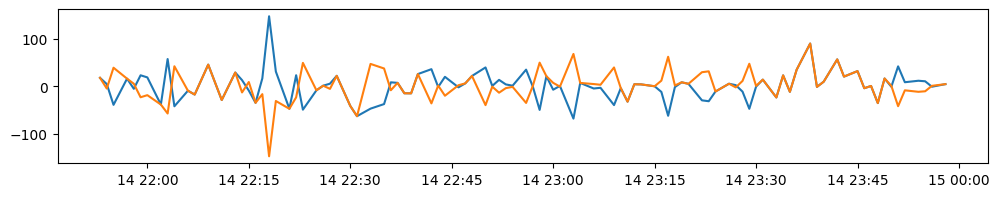

In [112]:
plt.figure(figsize=(12, 2))
for col in df_pred.columns[1:]:
    (np.sign(df_pred[col])[1:] * stock_real_movement.diff()[1:])
    plt.plot(timeline[1:], , label=col)
    plt.plot